In [1]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.interpolate import interp1d
import random
from scipy import interpolate

In [2]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

In [3]:
# date of datas
date = "0913"

ldr2hdr_dir = "./calibration/ldr2hdr/2023%s/"%date

# center points for all patches 20230913
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])


## Get R,G,B,W patches information

Text(0.5, 0, 'wavelength [nm]')

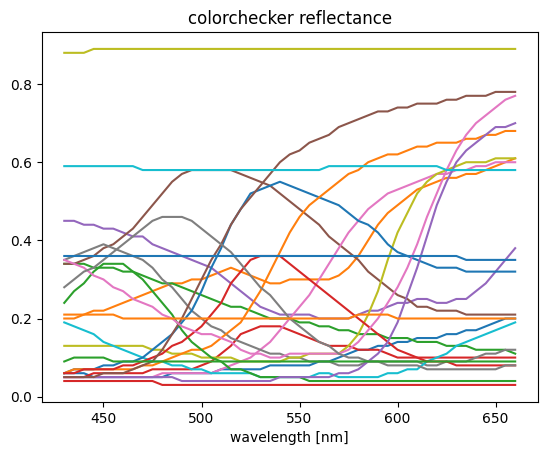

In [4]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

### Projector & Camera Response Function & DG efficiency

In [5]:
# bring initial value of PEF and CRF
PEF = np.load('./dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[3:27] # from 430nm

CRF = np.load('./dataset/image_formation/CRF.npy')[:,1:].T # from 430nm

dg_intensity = np.load('./dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

#### Interpolation for 5nm interval

In [6]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [7]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# interpolated CRF for 5nm
dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [8]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

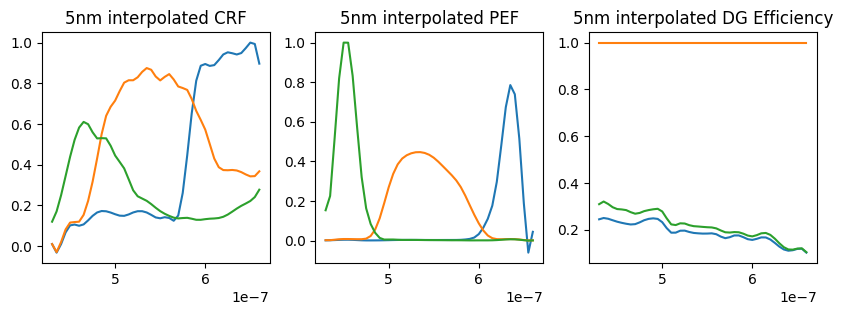

In [9]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF_intp.T), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF_intp.T), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, dg_intensity_intp.T), plt.title('5nm interpolated DG Efficiency')

#### Optimized parameter

In [10]:
# bring optimized parameters
opt_param_final = np.load('./calibration/radiometric_cal/opt_params/opt_param_0915_detach_09500.npy')

# update parameter
CRF = CRF_intp.T * opt_param_final[:,3:-2]
PEF = PEF_intp.T * opt_param_final[:,:3]
dg_intensity_intp[2] = dg_intensity_intp[2] * opt_param_final[:,-1]
dg_intensity_intp[0] = dg_intensity_intp[0] * opt_param_final[:,-2]
DG_efficiency = dg_intensity_intp

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

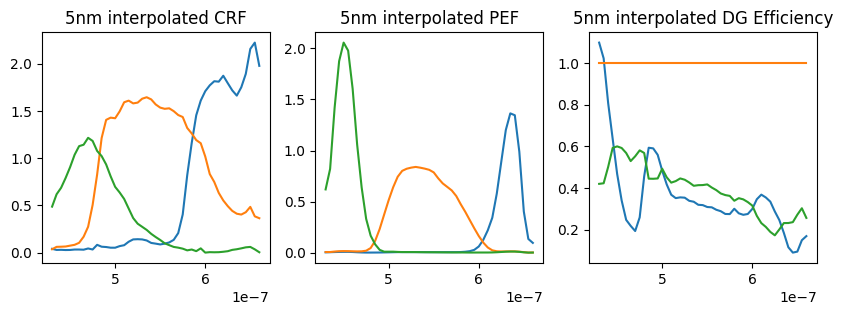

In [11]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

### Real Captured PPG Graph

In [12]:
# Real captured RGB Intensity graph
patches_rgb_real = np.load('./patches_rgb_real.npy')

#### Visualization

In [13]:
# # Visualization of PPG graph
# illum = np.arange(0, 318, 1)

# start_idx = 0
# end_idx = 318

# for p in range(n_patches):
#     plt.figure(figsize = (5,3))

#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 0], label = 'real red', c = 'red'), plt.legend(), plt.ylim(0,1)
#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 1], label = 'real green', c = 'green'), plt.legend(), plt.ylim(0,1)
#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 2], label = 'real blue', c = 'blue'), plt.legend(), plt.ylim(0,1)

#     plt.title('RGB intensity %s-th patch'%patch_idx[p])
#     plt.xlabel('illumination index')
#     plt.ylabel('rgb intensity')
    
#     # plt.savefig('./%sms_%02d-th_patch.png'%(ex_time[exp_indx],patch_idx[p]))

### Peak Illumination index

In [14]:
# bring peak illumination index
peak_illum_idx = np.load('./peak_illum_idx.npy') # num patch, wvls (430nm - 660nm except 630nm)

In [15]:
peak_illum_idx[18, 0] = 204 # for white patch

In [16]:
# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

# interpolated index 430 ~ 660 nm for 10nm interval
peak_illum_idx_intp = []
for p in range(n_patches):
    peak_illum_idx_intp.append(cubic_interpolation(new_wvls, wvls, peak_illum_idx[p], 4).astype(np.int16))
peak_illum_idx_intp = np.array(peak_illum_idx_intp)

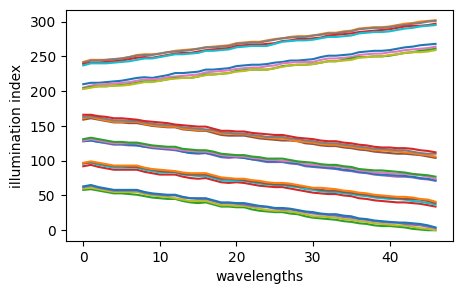

In [17]:
plt.figure(figsize=(5,3))
for p in range(n_patches):
    plt.plot(peak_illum_idx_intp[p]) # n_patches, wvls (47, 5nm interval)
    plt.xlabel('wavelengths')
    plt.ylabel('illumination index')

In [18]:
position_430nm = peak_illum_idx_intp[:,0]
position_660nm = peak_illum_idx_intp[:,-1]

start_idx = position_430nm
end_idx = position_660nm

peak_illum_idx_final = []
for p in range(n_patches):
    interval_array = np.linspace(start_idx[p], end_idx[p], 47)
    interval_array = np.round(interval_array).astype(np.int16)
    peak_illum_idx_final.append(interval_array)

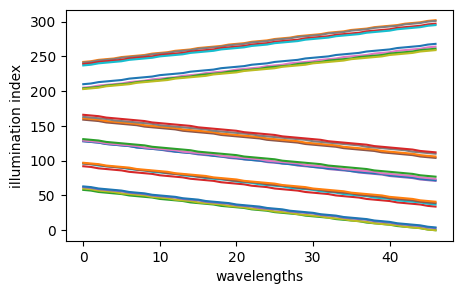

In [19]:
plt.figure(figsize=(5,3))
for p in range(n_patches):
    plt.plot(peak_illum_idx_final[p]) # n_patches, wvls (47, 5nm interval)
    plt.xlabel('wavelengths')
    plt.ylabel('illumination index')

### Visualization for only first order dispersed graph

In [20]:
# for p in range(n_patches):
#     plt.figure(figsize=(5,3))
#     plt.ylim([0,1])
#     plt.xlabel('wavelengths 430nm - 660nm')
#     plt.ylabel('RGB intensity')
#     plt.plot(patches_rgb_real[peak_illum_idx_final[p], p]), plt.title('%02d patch'%p)

### GT Reflectance, Simulation for first order RGB Intensity

In [87]:
wvls.shape, new_wvls.shape

(torch.Size([23]), torch.Size([47]))

In [88]:
patch_num = 18

# white pattern
white_patt = np.ones(shape = (1, 3)) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

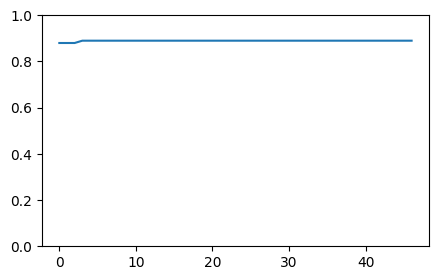

In [89]:
plt.figure(figsize=(5,3))
plt.ylim([0, 1])
plt.plot(ref_CC[:,patch_num])

In [90]:
# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# test with GT reflectance for all patches
total_patch = []
for p in range(n_patches):
    if p in pfirst_patches:
        dg_eff = DG_efficiency[2]
    else:
        dg_eff = DG_efficiency[0]
        
    I_C = ref_CC[:,p][:,np.newaxis] * CRF * white_patt_hyp[:,np.newaxis] * dg_eff[:,np.newaxis]

    total_patch.append(I_C)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


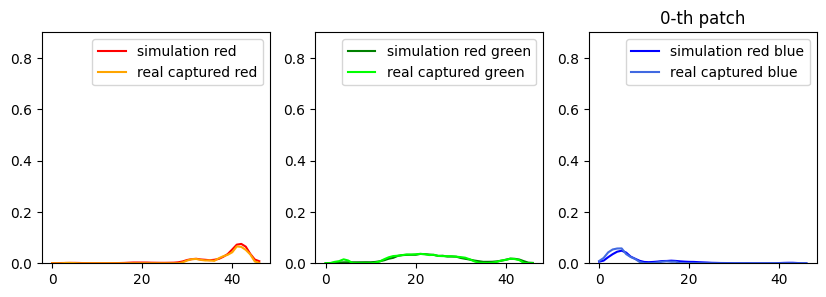

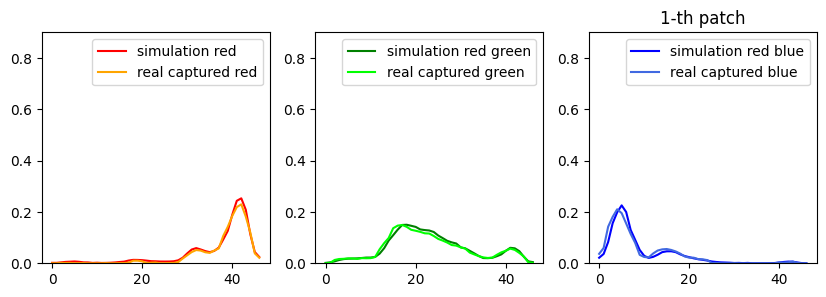

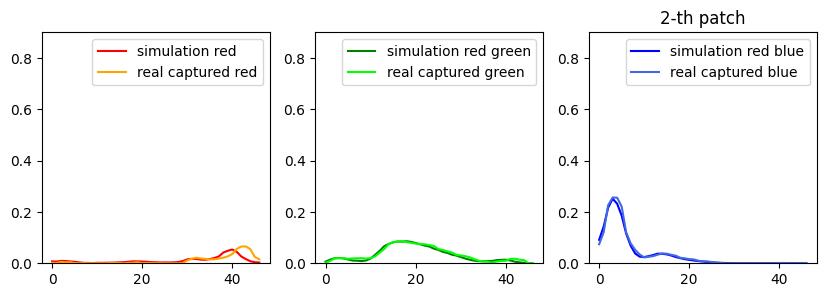

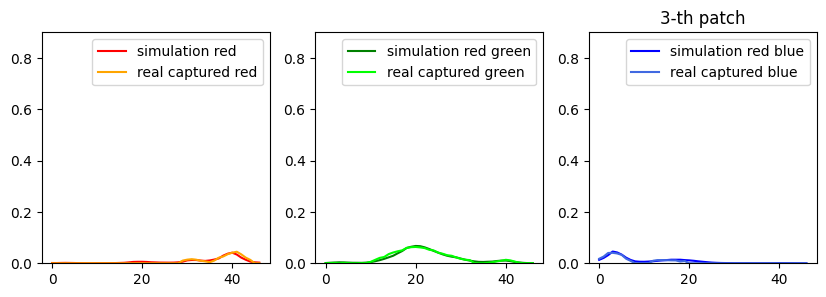

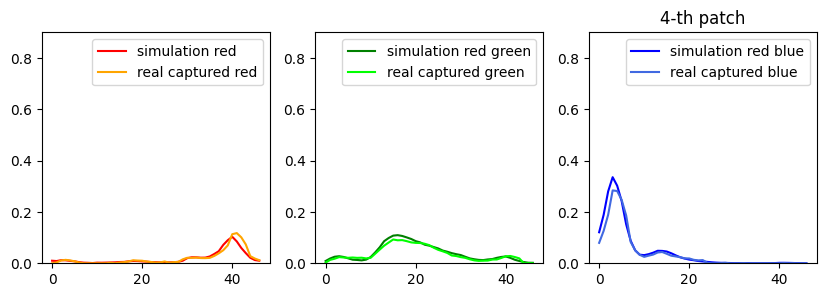

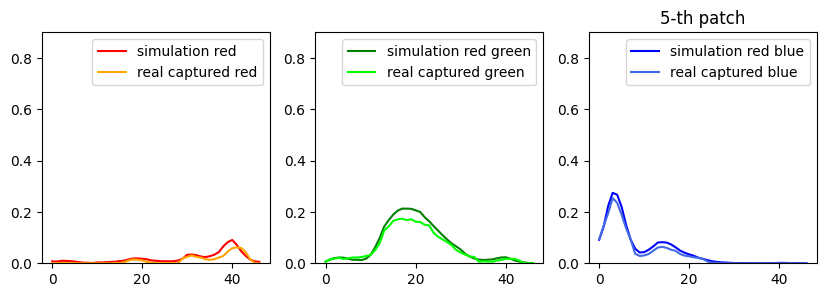

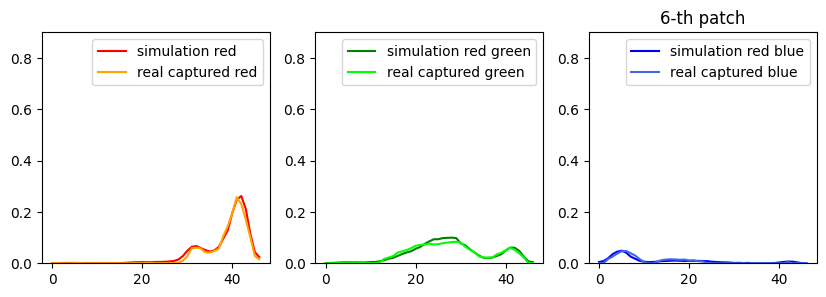

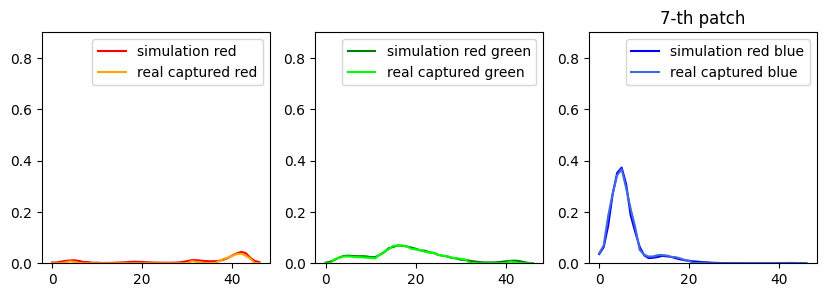

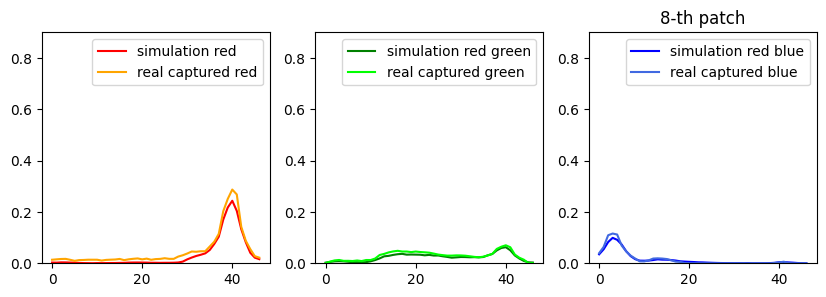

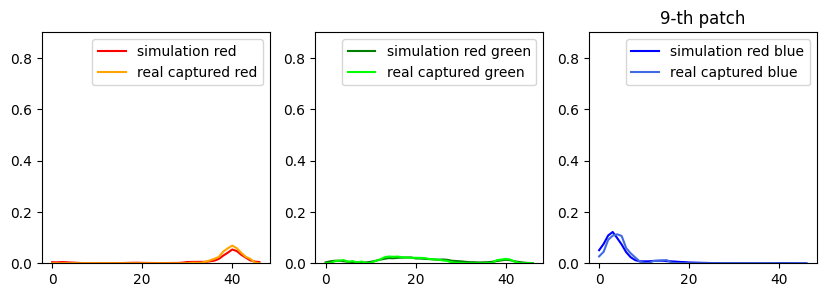

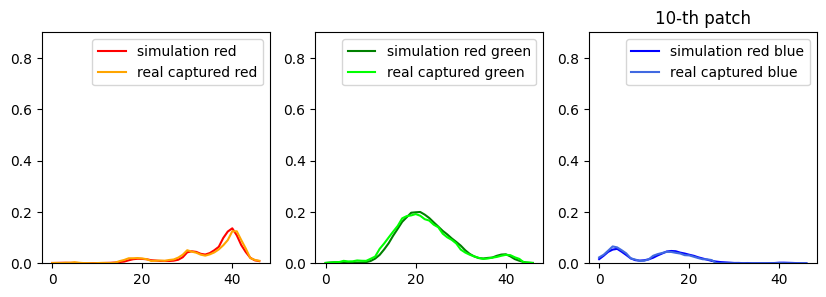

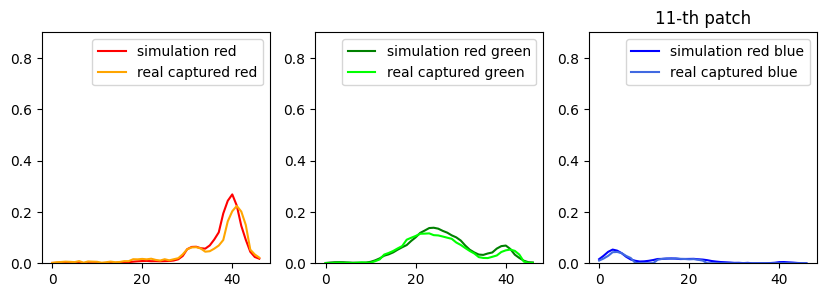

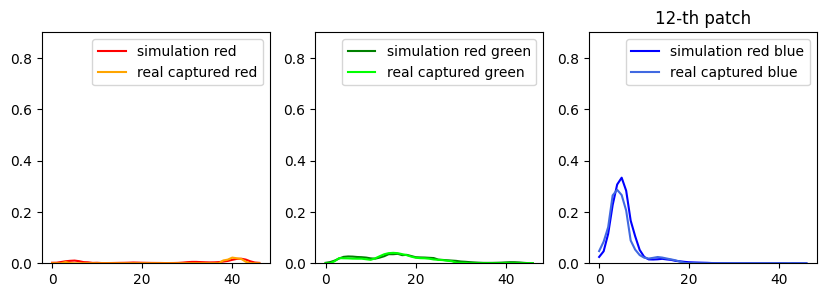

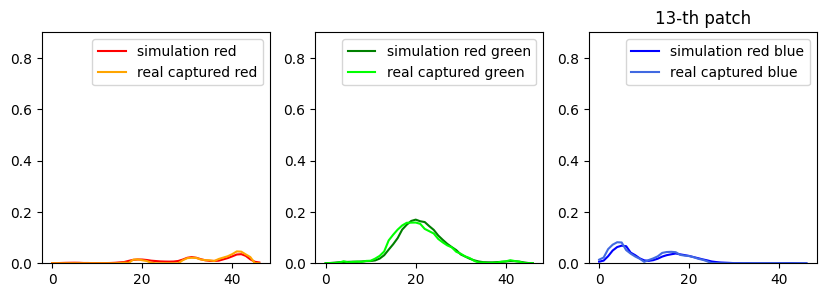

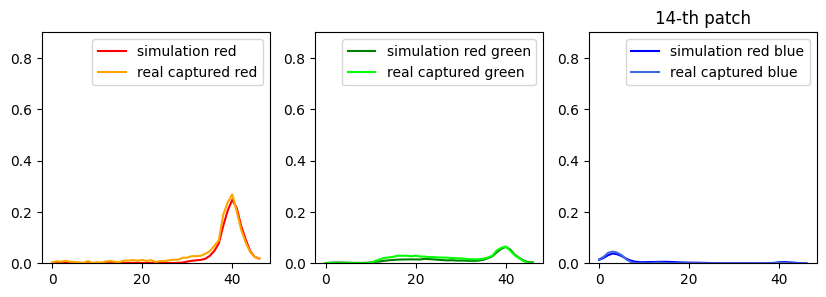

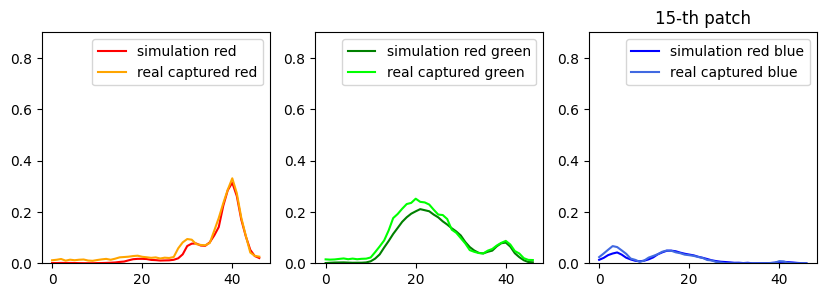

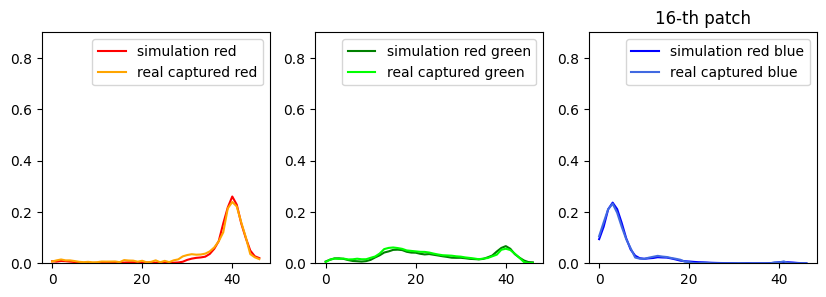

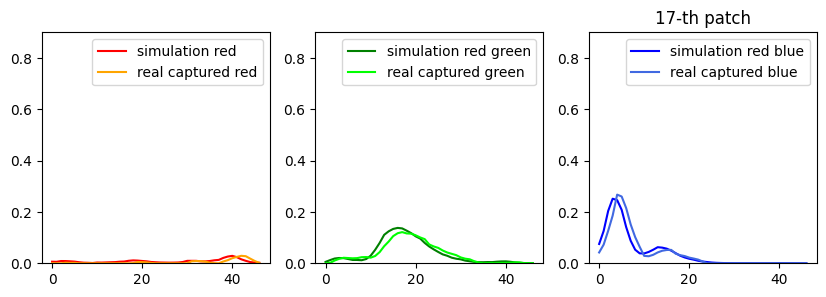

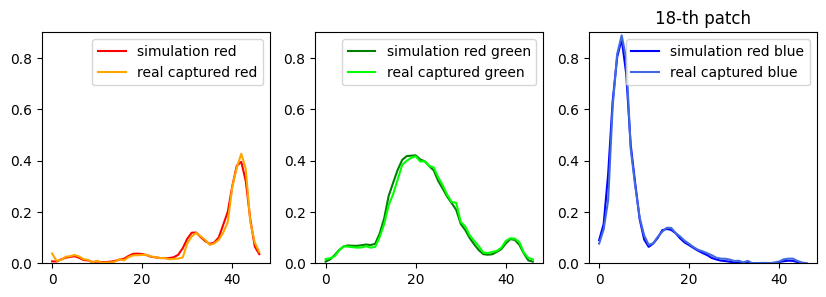

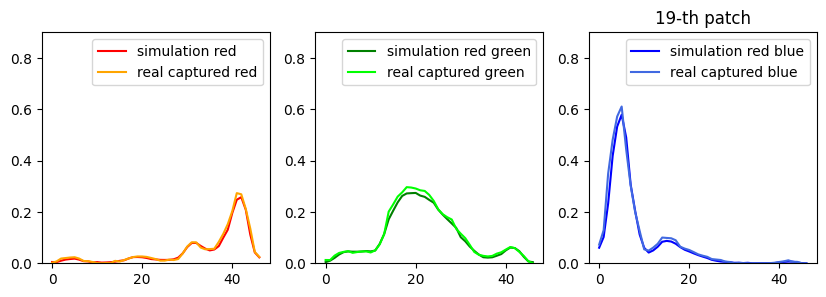

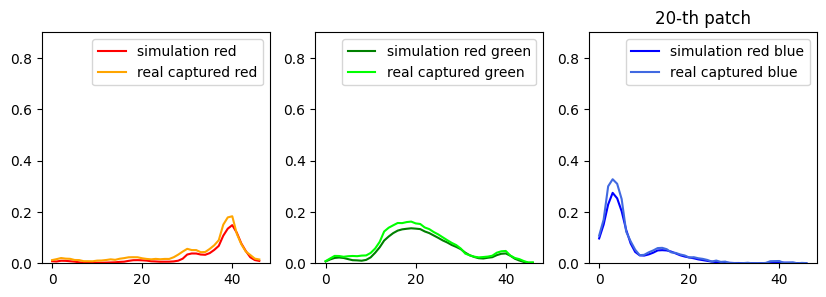

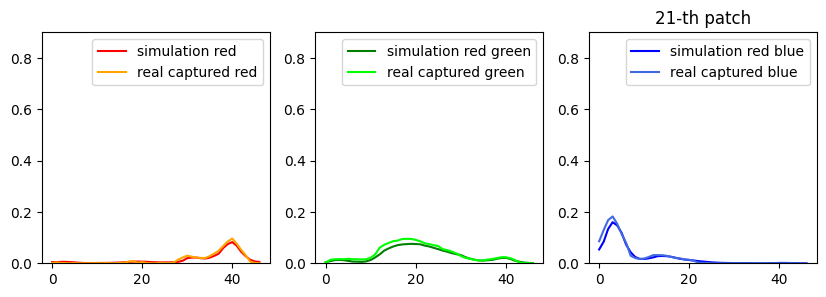

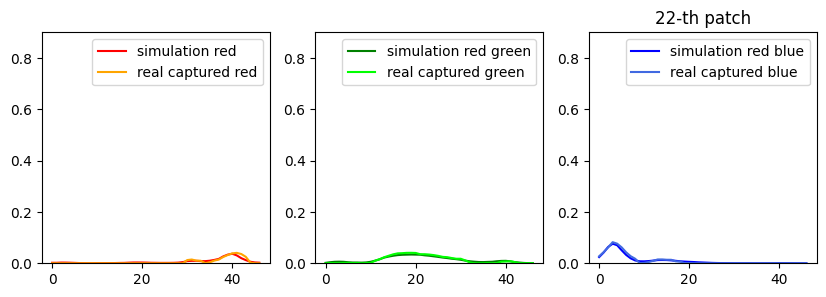

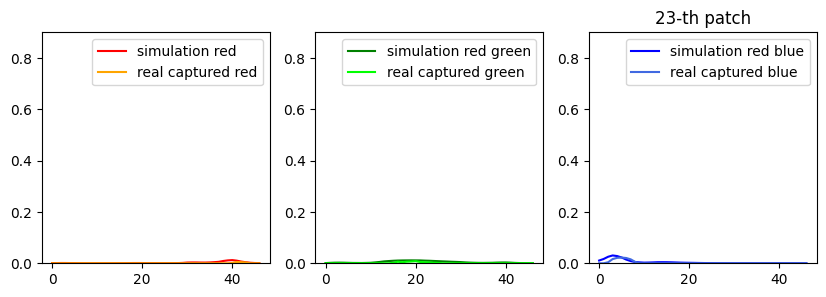

In [91]:
constant = 1
max_ylim = 0.9

# plot 1st order rgb intensity for all patches
for p in range(n_patches): # only visualize white patch       
    plt.figure(figsize=(10,3))
    plt.ylim([0, 1])
    
    # red
    plt.subplot(131), plt.plot(total_patch[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.subplot(131), plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,0], c = 'orange', label = 'real captured red')
    plt.legend()
    plt.ylim([0, max_ylim])
    
    # green
    plt.subplot(132), plt.plot(total_patch[p][:,1]* constant, c = 'green', label = 'simulation red green')
    plt.subplot(132), plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    plt.ylim([0, max_ylim])
    
    # blue
    plt.subplot(133), plt.plot(total_patch[p][:,2]* constant, c = 'blue', label = 'simulation red blue')
    plt.subplot(133), plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,2], c = 'royalblue', label = 'real captured blue')
    plt.ylim([0, max_ylim])
    
    plt.title('%s-th patch'%p)
    
    plt.savefig('%02d_patch'%p)
    
    plt.legend()

### Hyperspectral Reconstruction

In [92]:
# white pattern
white_patt = np.ones(shape = (1, 3)) * 0.8
white_patt_hyp = white_patt @ PEF.T
white_patt_hyp = white_patt_hyp.squeeze()

In [93]:
# summation of CRF RGB channel
CRF_sum = CRF.sum(axis = 1)

In [94]:
total_hyp_ref = []
for p in range(n_patches):
    if p in pfirst_patches:
        dg_eff = DG_efficiency[2]
    else:
        dg_eff = DG_efficiency[0]
        
    # summation of Image RGB channel
    
    I_C = patches_rgb_real[peak_illum_idx_final[p], p].sum(axis = 1)
    hyp_ref = (I_C / ( CRF_sum * white_patt_hyp * dg_eff))
    
    total_hyp_ref.append(hyp_ref)
    
total_hyp_ref = np.array(total_hyp_ref)

In [95]:
# for p in range(n_patches):
#     plt.figure(figsize=(5,3))
#     plt.ylim([0,1])
#     plt.plot(total_hyp_ref[p])
#     plt.plot(ref_CC[:,p])
#     plt.title('%02d patch'%p)
#     plt.savefig('%02d_patch_reconstruction.png'%p)

### Optimization Method

In [28]:
peak_illum_idx_final = np.array(peak_illum_idx_final)

In [32]:
patches_rgb_real.shape,patches_rgb_real[:,0].shape, peak_illum_idx_final[0].shape

((318, 24, 3), (318, 3), (47,))

In [25]:
patches_rgb_real[peak_illum_idx_final[0],0].shape

(47, 3)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/5000, Loss: 0.07889370620250702, LR: 0.003
Epoch : 500/5000, Loss: 0.0050206926340858144, LR: 0.003
Epoch : 1000/5000, Loss: 0.005022091170152028, LR: 0.003
Epoch : 1500/5000, Loss: 0.005021631407241027, LR: 0.003
Epoch : 2000/5000, Loss: 0.005022741854190826, LR: 0.003
Epoch : 2500/5000, Loss: 0.005023278916875522, LR: 0.003
Epoch : 3000/5000, Loss: 0.005022729746997356, LR: 0.0015
Epoch : 3500/5000, Loss: 0.005016097488502662, LR: 0.0015
Epoch : 4000/5000, Loss: 0.005016873280207316, LR: 0.0015
Epoch : 4500/5000, Loss: 0.005016427797575791, LR: 0.0015


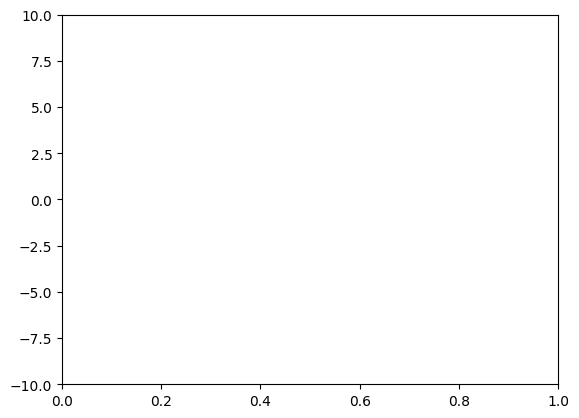

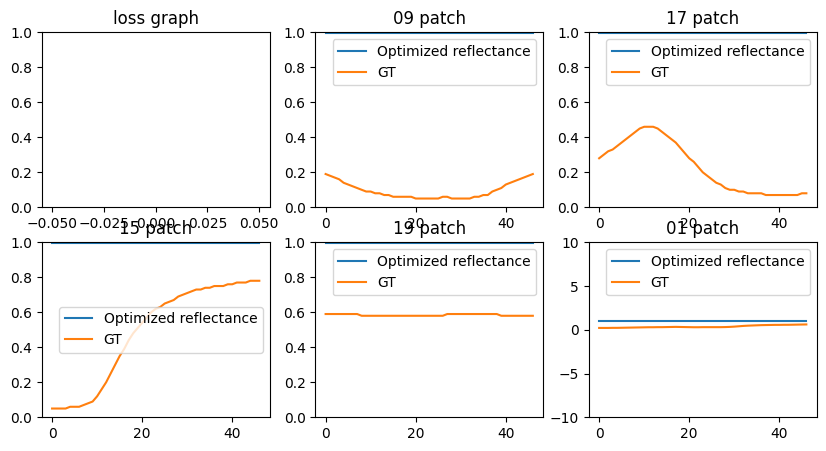

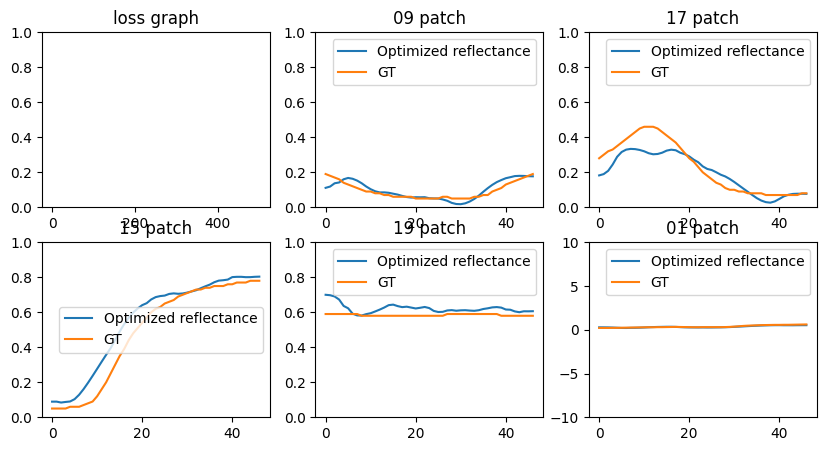

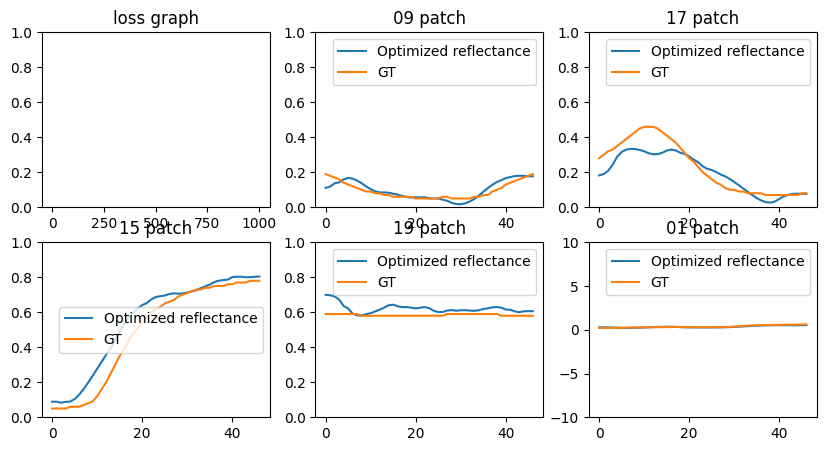

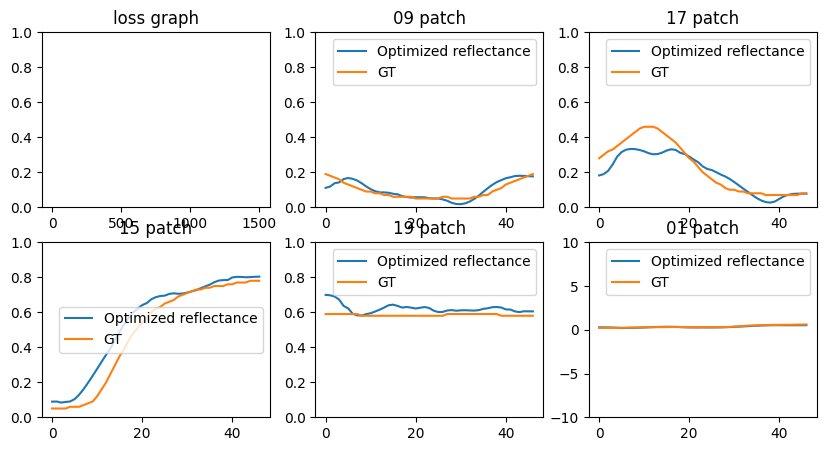

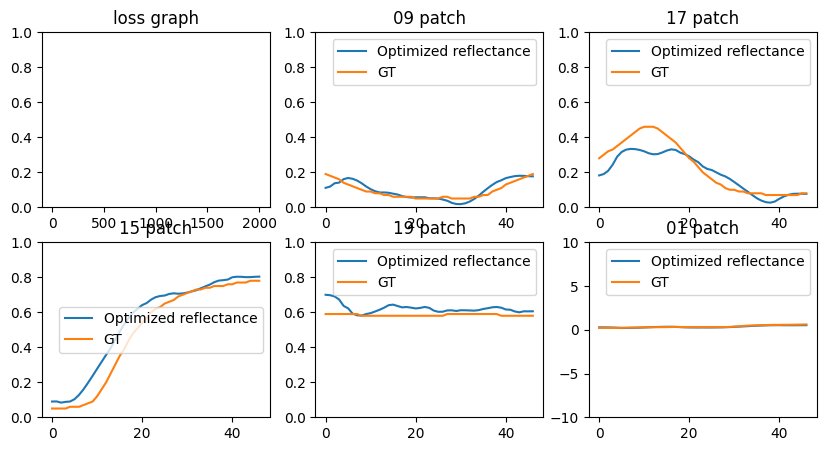

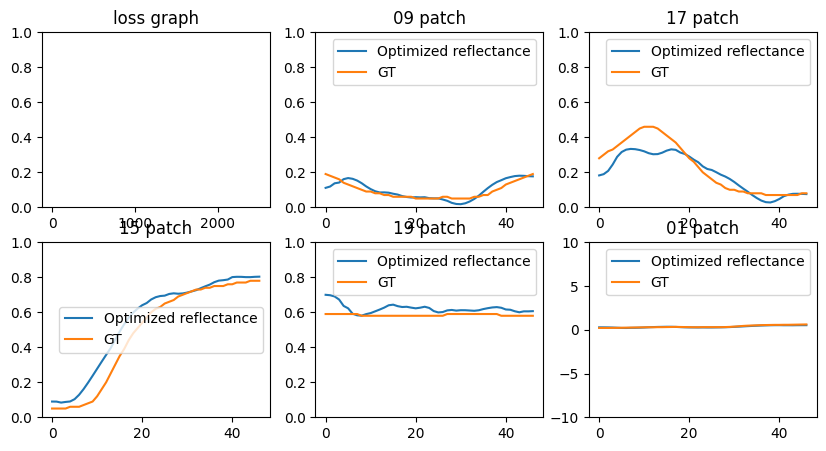

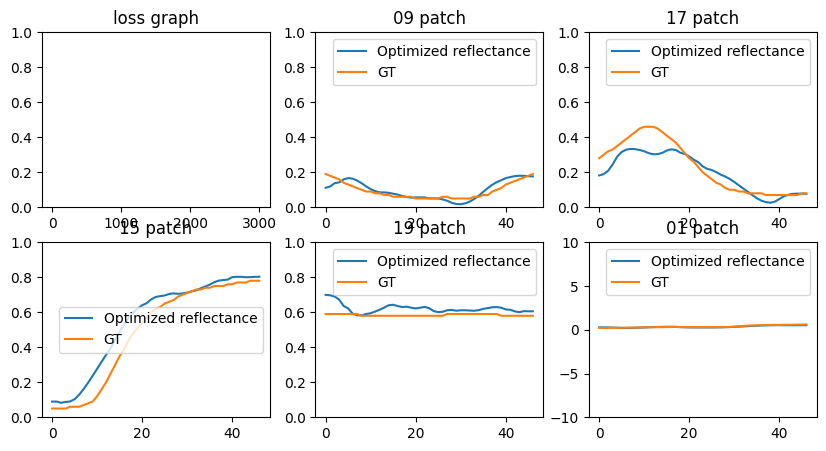

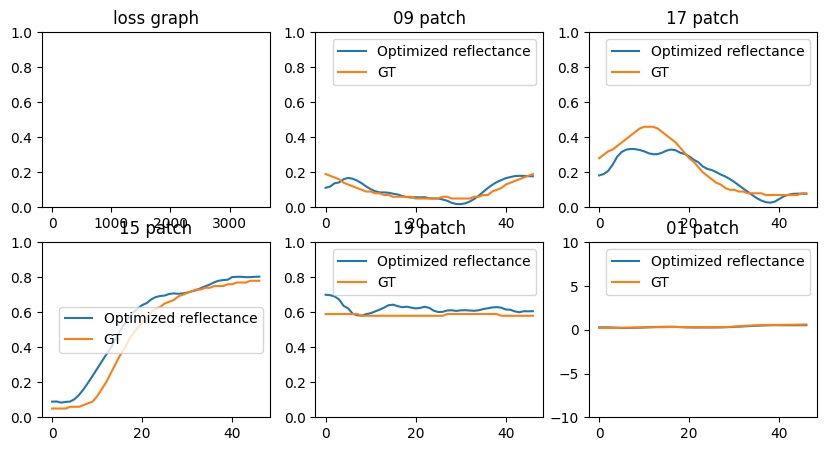

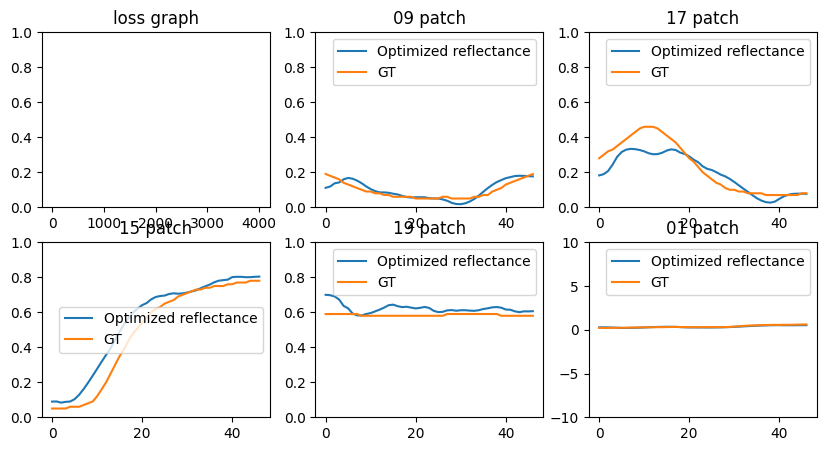

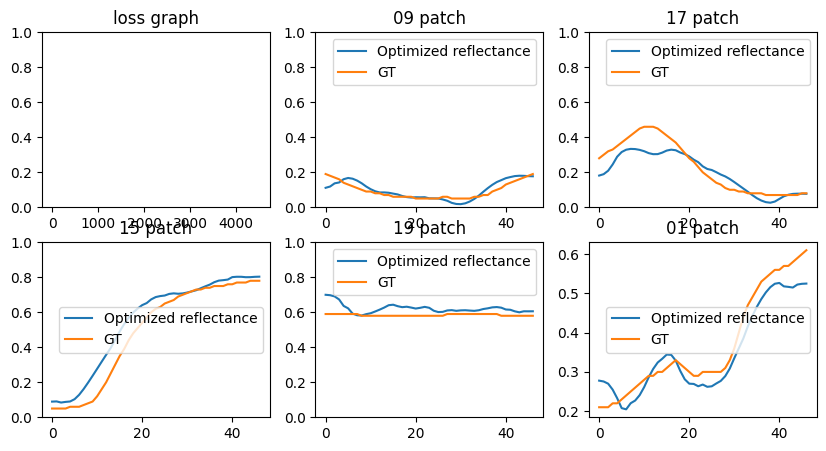

In [96]:
# arguments
device = 'cuda:0'
epoch = 5000
loss_f = torch.nn.L1Loss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.003
decay_step = 3000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(24, 47))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
DG_efficiency_dev = torch.tensor(DG_efficiency, dtype = torch.float).to(device)

patches_rgb_real_device = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_device = torch.tensor(peak_illum_idx_final, dtype = torch.long).to(device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

for i in range(epoch):
    # initial loss
    loss = 0
        
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_dev

    # loss for all patches
    # for p in opt_patch_idx:
    for p in range(n_patches-2):
        if p in pfirst_patches:
            dg_eff = DG_efficiency_dev[2]
        else:
            dg_eff = DG_efficiency_dev[0]
                            # 1, 47                         3, 47       1, 47               1, 47
        Simulated_I_RGB = opt_param[p].unsqueeze(dim = 1) * CRF_dev * white_pattern_hyp.T * dg_eff.unsqueeze(dim = 1)
        GT_I_RGB = patches_rgb_real_device[peak_illum_idx_final_device[p], p]
        
        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        loss += single_patch_loss.sum()
    
    hyp_dL2 = ((opt_param[:,:-1] - opt_param[:,1:])**2).sum()

    weight = 0.15
    loss += weight*(hyp_dL2)

    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / num_patch)
    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / num_patch}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        
        patches_rgb_real_device[peak_illum_idx_final_device[p], p]
        
        
        np.save('./calibration/radiometric_cal/opt_params/hyp_0915_detach_%05d.npy'%i, opt_param_detach)
        
        plt.ylim([-10, 10])
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # p = [random.randint(0, 21) for _ in range(5)]
        
        # Hyperspectral reconstruction
        plt.ylim([0,1])
        plt.subplot(232), plt.plot(opt_param_detach[rand_idx[0]], label = 'Optimized reflectance')
        plt.subplot(232), plt.plot(ref_CC[:,rand_idx[0]], label = 'GT'), plt.title('%02d patch'%rand_idx[0])
        plt.legend()
        
        plt.ylim([0,1])
        plt.subplot(233), plt.plot(opt_param_detach[rand_idx[1]], label = 'Optimized reflectance')
        plt.subplot(233), plt.plot(ref_CC[:,rand_idx[1]], label = 'GT'), plt.title('%02d patch'%rand_idx[1])
        plt.legend()
        
        plt.ylim([0,1])
        plt.subplot(234), plt.plot(opt_param_detach[rand_idx[2]], label = 'Optimized reflectance')
        plt.subplot(234), plt.plot(ref_CC[:,rand_idx[2]], label = 'GT'), plt.title('%02d patch'%rand_idx[2])
        plt.legend()
        
        plt.ylim([0,1])
        plt.subplot(235), plt.plot(opt_param_detach[rand_idx[3]], label = 'Optimized reflectance')
        plt.subplot(235), plt.plot(ref_CC[:,rand_idx[3]], label = 'GT'), plt.title('%02d patch'%rand_idx[3])
        plt.legend()
        
        plt.ylim([0,1])
        plt.subplot(236), plt.plot(opt_param_detach[rand_idx[4]], label = 'Optimized reflectance')
        plt.subplot(236), plt.plot(ref_CC[:,rand_idx[4]], label = 'GT'), plt.title('%02d patch'%rand_idx[4])
        plt.legend()

In [97]:
hyp_recon = np.load('./calibration/radiometric_cal/opt_params/hyp_0915_detach_%05d.npy'%4500)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


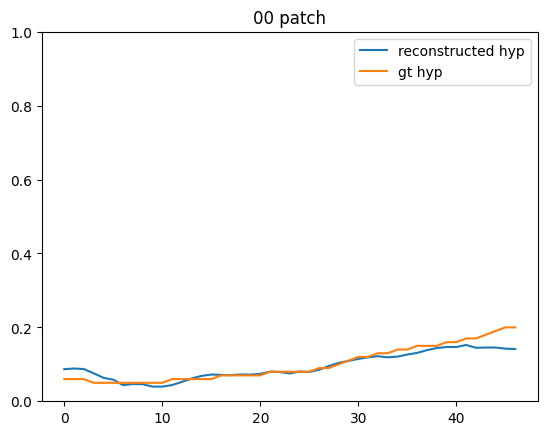

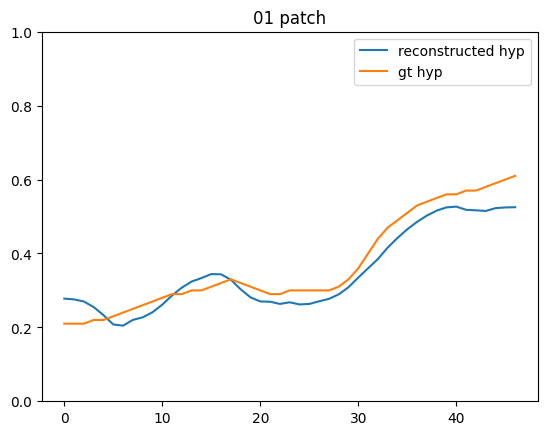

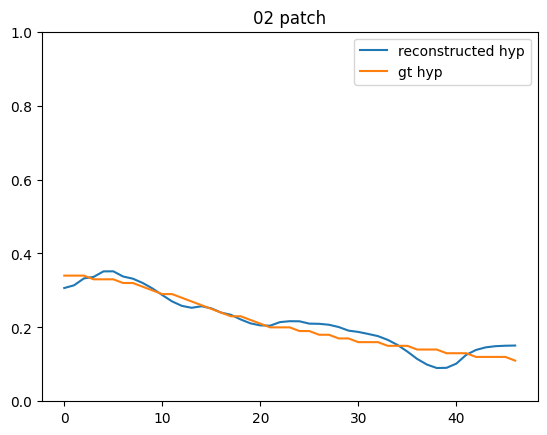

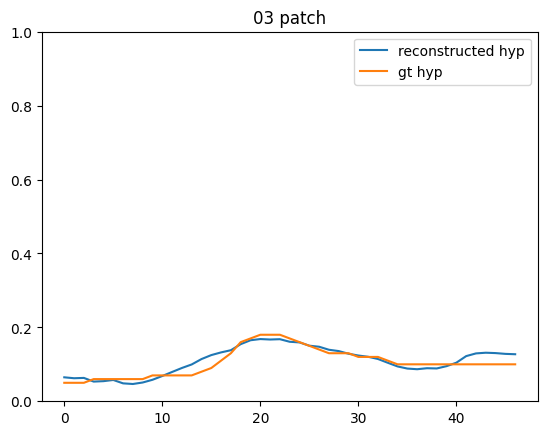

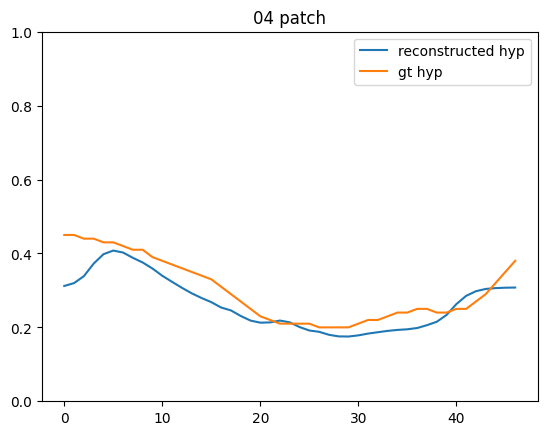

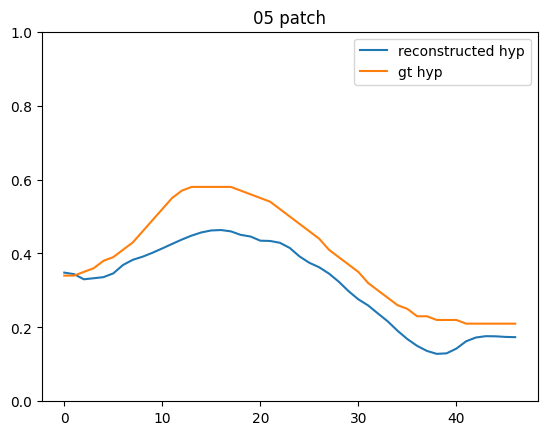

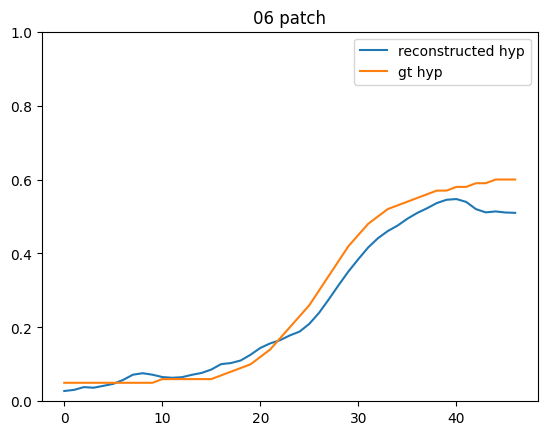

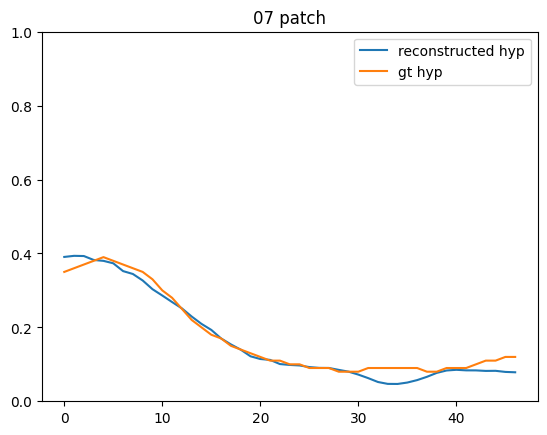

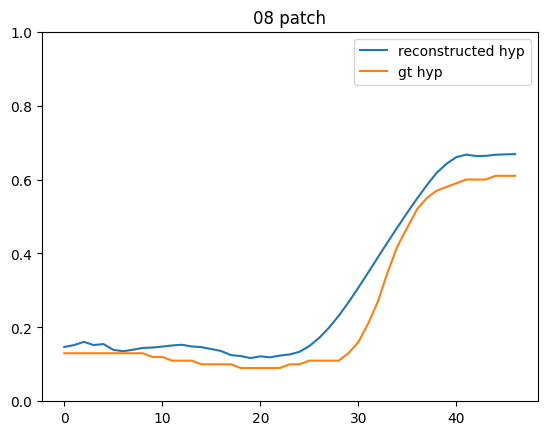

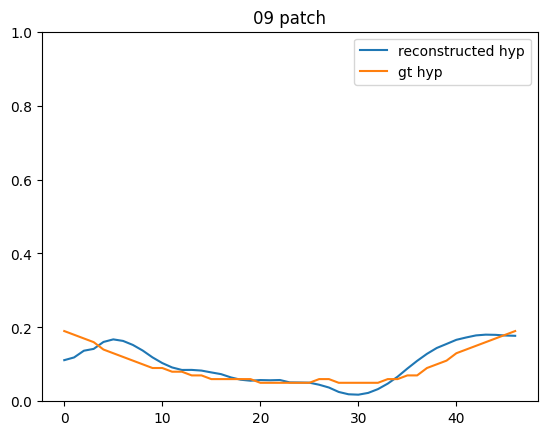

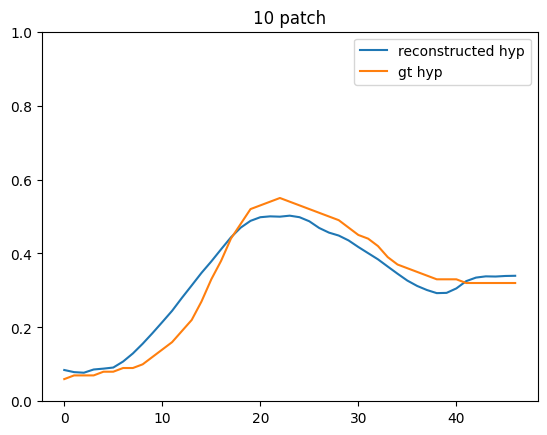

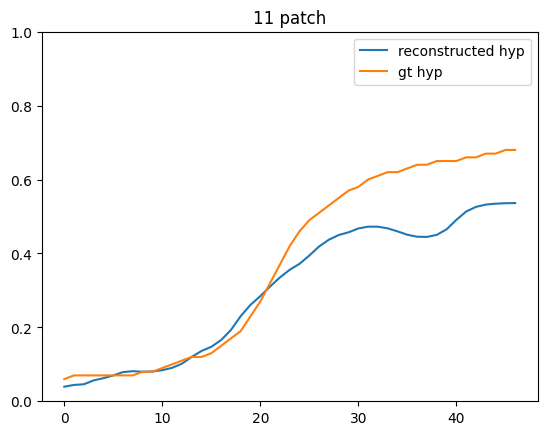

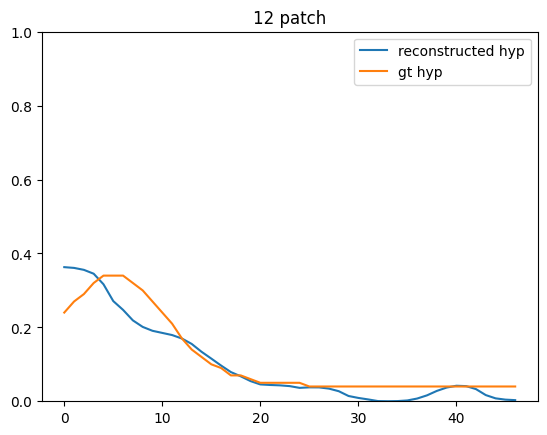

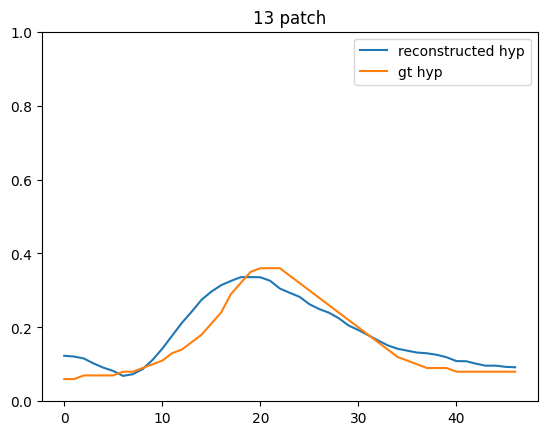

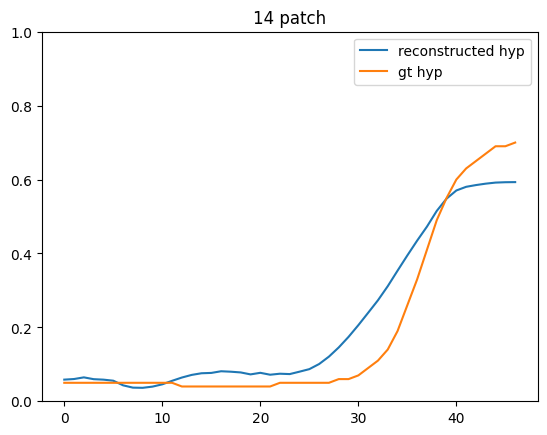

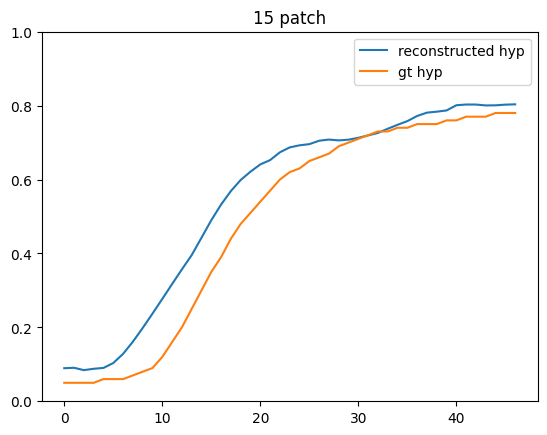

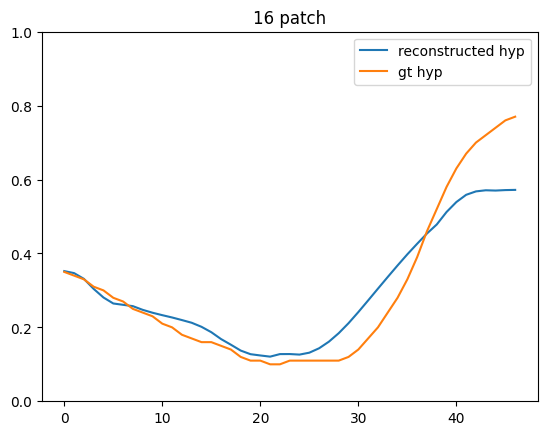

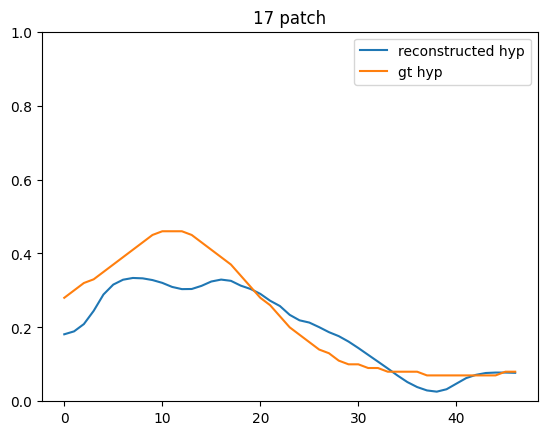

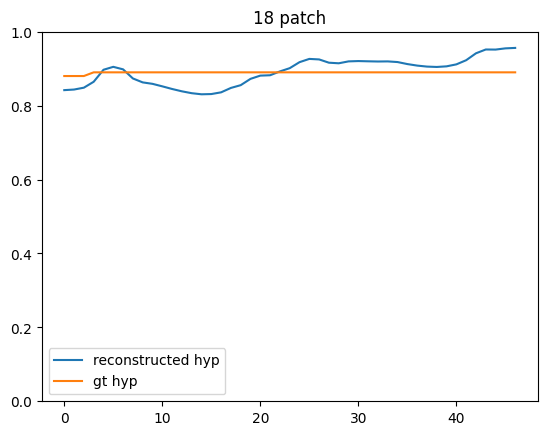

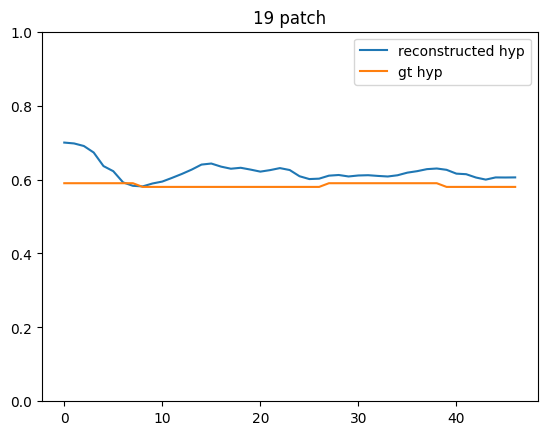

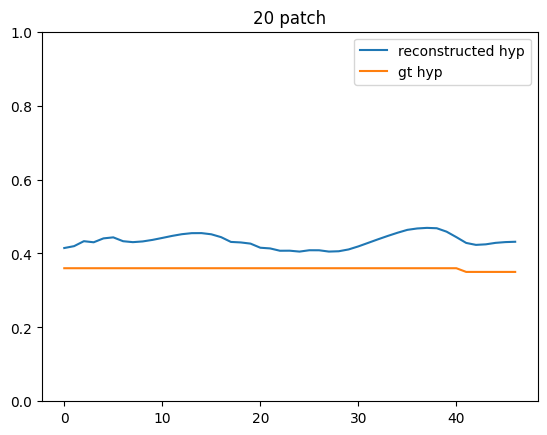

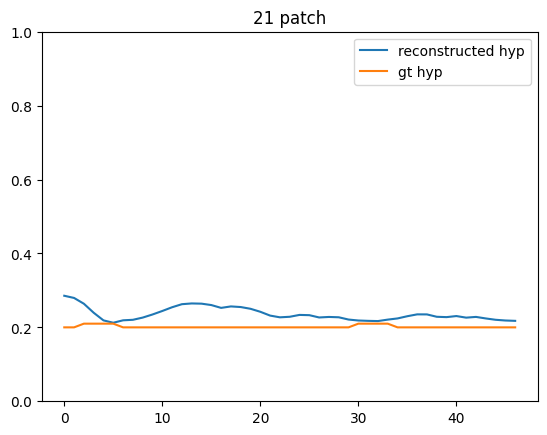

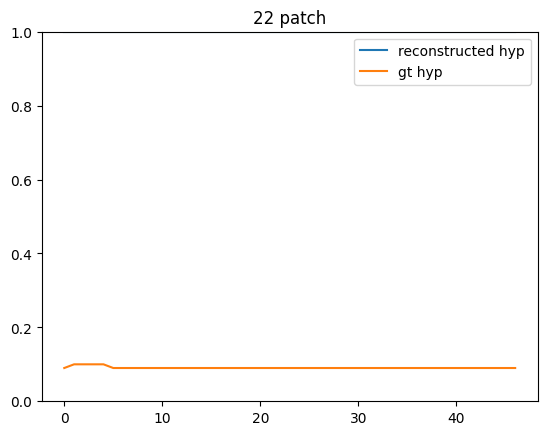

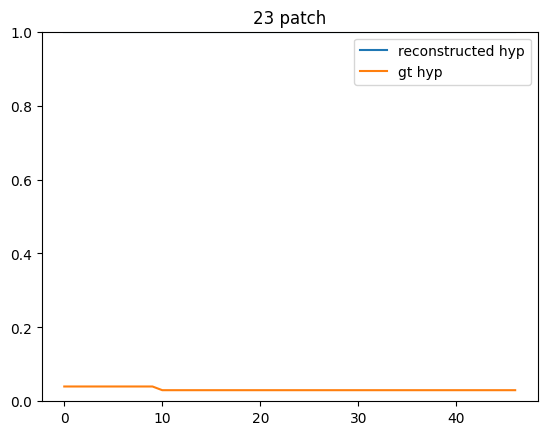

In [99]:
for p in range(n_patches):
    plt.figure()
    plt.ylim([0,1])
    plt.plot(hyp_recon[p], label = 'reconstructed hyp'), plt.title('%02d patch'%p)
    plt.plot(ref_CC[:,p], label = 'gt hyp')
    plt.legend()
    plt.savefig('./%02d_patch_recon'%p)